In [24]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Flatten,Dropout
import keras
from keras.utils import save_img
import matplotlib.pyplot as plt
import os

In [25]:
PATH='C:/Users/olkab/Desktop/Project Rhyme/Rhymes/rhymes_dataset/rhymes_17500x40.csv'
df = pd.read_csv(PATH)
# df2 = pd.read_csv("D:/Inteligentne usługi informacyjne/scrapping/rhymes_i.csv")
# df3 = pd.read_csv("D:/Inteligentne usługi informacyjne/scrapping/rhymes_small.csv")
# df4 = pd.read_csv("D:/Inteligentne usługi informacyjne/scrapping/rhymes_small_2.csv")
# df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)
print(f'Data length {len(df["base_word"])}')

Data length 700000


In [26]:
# Tokenize words
polish_alphabet = 'aąbcćdeęfghijklłmnńoópqrsśtuvwyzźż'
tokenizer = Tokenizer(char_level=True, filters=None, lower=True)
tokenizer.fit_on_texts(polish_alphabet)

# Convert characters to numerical sequences
seq_word1 = tokenizer.texts_to_sequences(df['base_word'])
seq_word2 = tokenizer.texts_to_sequences(df['rhyme_candidate'])

max_sequence_length = 20
pad_word1 = pad_sequences(seq_word1, maxlen=max_sequence_length)
pad_word2 = pad_sequences(seq_word2, maxlen=max_sequence_length)

x = np.concatenate((pad_word1, pad_word2), axis=-1)
y = df['score'].values

In [27]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [28]:
print(f'Train dataset {len(x_train)} validation dataset {len(x_val)}')

Train dataset 560000 validation dataset 140000


In [29]:
embedding_dim = 8  # Adjust as needed
vocab_size = len(tokenizer.word_index) + 1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=2*max_sequence_length),
    Flatten(),
    # LSTM(units=64),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')  # Output layer for binary classification
])

model2=Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=2*max_sequence_length),
            Flatten(),
            Dense(464,activation='relu'),
            Dense(50,activation='relu'),
            Dropout(0.2),
            Dense(25,activation='relu'),
            Dropout(0.2),
            Dense(16,activation='relu'),
            Dropout(0.2),
            Dense(8,activation='relu'),
            Dropout(0.2),
            Dense(1,activation='sigmoid'),
])

model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=2*max_sequence_length),
    LSTM(units=64),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')  # Output layer for binary classification
])


In [30]:
def predict(word_1, word_2):
    seq_word1 = tokenizer.texts_to_sequences([word_1])
    seq_word2 = tokenizer.texts_to_sequences([word_2])

    max_sequence_length = 20
    pad_word1 = pad_sequences(seq_word1, maxlen=max_sequence_length)
    pad_word2 = pad_sequences(seq_word2, maxlen=max_sequence_length)

    x = np.concatenate((pad_word1, pad_word2), axis=-1)
    raw_result=model.predict(x)[0]
    result=np.round(raw_result)
    return result,raw_result

In [31]:
def training(model_name:str,model,epochs:int,optimizer,batch_size:int,optimizer_name:str):
    checkpoint_filepath = f'models/{model_name}/{model_name}_{epochs}_{batch_size}_{optimizer_name}.weights.h5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

    callback = keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.001,patience=3,verbose=1)
    callbacks=[model_checkpoint_callback,callback]
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history=model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val),callbacks=callbacks)

    return history

In [32]:
def plot_save_charts(model_setting,history):
    os.makedirs(name=f'models/{model_setting["model_name"]}/charts',exist_ok=True)
    params=[['accuracy','val_accuracy'],['loss','val_loss']]
    for param in params:
        plt.plot(history.history[param[0]])
        plt.plot(history.history[param[1]])
        plt.title(f'Model {param[0]}')
        plt.ylabel(param[0])
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.savefig(f'models/{model_setting["model_name"]}/charts/{model_setting["model_name"]}_{model_setting["optimizer_name"]}_{model_setting["batch_size"]}_{param[0]}.png')
        plt.clf()

In [33]:
settings=[{
    'model':model,
    'model_name':'model1',
    'epochs':10,
    'optimizer':keras.optimizers.SGD(learning_rate=0.01),  
    'optimizer_name':'SGD',  
    'batch_size':32

    },
    {
    'model':model,
    'model_name':'model1',
    'epochs':10,
    'optimizer':keras.optimizers.Adam(learning_rate=0.01),
    'optimizer_name':'Adam',  
    'batch_size':64

  },
  {
    'model':model,
    'model_name':'model1',
    'epochs':10,
    'optimizer':keras.optimizers.SGD(learning_rate=0.001),
    'optimizer_name':'SGD',  
    'batch_size':64

},
  {
    'model':model,
    'model_name':'model1',
    'epochs':10,
    'optimizer':keras.optimizers.Adam(learning_rate=0.001),
    'optimizer_name':'Adam',  
    'batch_size':32

},
{
    'model':model2,
    'model_name':'model2',
    'epochs':10,
    'optimizer':keras.optimizers.SGD(learning_rate=0.01),
    'optimizer_name':'SGD',  
    'batch_size':32

    },
    {
    'model':model2,
    'model_name':'model2',
    'epochs':10,
    'optimizer':keras.optimizers.Adam(learning_rate=0.01),
    'optimizer_name':'Adam',  
    'batch_size':64

},
  {
    'model':model2,
    'model_name':'model2',
    'epochs':10,
    'optimizer':keras.optimizers.SGD(learning_rate=0.001),
    'optimizer_name':'SGD',  
    'batch_size':64

},
  {
    'model':model2,
    'model_name':'model2',
    'epochs':10,
    'optimizer':keras.optimizers.Adam(learning_rate=0.001),
    'optimizer_name':'Adam',  
    'batch_size':32

  },
  {
    'model':model3,
    'model_name':'model3',
    'epochs':10,
    'optimizer':keras.optimizers.Adam(learning_rate=0.01),
    'optimizer_name':'Adam',  
    'batch_size':32

    },
    {
    'model':model3,
    'model_name':'model3',
    'epochs':10,
    'optimizer':keras.optimizers.SGD(learning_rate=0.01),
    'optimizer_name':'SGD',  
    'batch_size':64

},
  {
    'model':model3,
    'model_name':'model3',
    'epochs':10,
    'optimizer':keras.optimizers.Adam(learning_rate=0.001),
    'optimizer_name':'Adam',  
    'batch_size':64

},
  {
    'model':model3,
    'model_name':'model3',
    'epochs':10,
    'optimizer':keras.optimizers.SGD(learning_rate=0.001),
    'optimizer_name':'SGD',  
    'batch_size':32

}
]

In [34]:
for i in range(len(settings)):
    epochs=settings[i]['epochs']
    batch_size=settings[i]['batch_size']
    optimizer=settings[i]['optimizer']
    optimizer_name=settings[i]['optimizer_name']
    model_name=settings[i]['model_name']
    model=settings[i]['model'] 
    print(settings[i])
    history=training(model_name=model_name,model=model,epochs=epochs,optimizer=optimizer,batch_size=batch_size,optimizer_name=optimizer_name)
    plot_save_charts(model_setting=settings[i],history=history)
    with open(f'models/{model_name}/model_result_{optimizer_name}__{batch_size}.txt','w') as f:
        f.write(f'Results {history.history}')
        f.write(f'Param {history.params}')
    keras.backend.clear_session()
    model. reset_states()

{'model': <keras.src.engine.sequential.Sequential object at 0x000001762AF46990>, 'model_name': 'model1', 'epochs': 10, 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x000001760636B290>, 'optimizer_name': 'SGD', 'batch_size': 32}
Epoch 1/10


17500/17500 [==============================] - 33s 2ms/step - loss: 0.3841 - accuracy: 0.8162 - val_loss: 0.1869 - val_accuracy: 0.9252
Epoch 2/10
17500/17500 [==============================] - 31s 2ms/step - loss: 0.1140 - accuracy: 0.9609 - val_loss: 0.0871 - val_accuracy: 0.9708
Epoch 3/10
17500/17500 [==============================] - 32s 2ms/step - loss: 0.0752 - accuracy: 0.9751 - val_loss: 0.0662 - val_accuracy: 0.9778
Epoch 4/10
17500/17500 [==============================] - 36s 2ms/step - loss: 0.0583 - accuracy: 0.9808 - val_loss: 0.0543 - val_accuracy: 0.9819
Epoch 5/10
17500/17500 [==============================] - 34s 2ms/step - loss: 0.0484 - accuracy: 0.9842 - val_loss: 0.0464 - val_accuracy: 0.9848
Epoch 6/10
17500/17500 [==============================] - 35s 2ms/step - loss: 0.0414 - accuracy: 0.9866 - val_loss: 0.0421 - val_accuracy: 0.9864
Epoch 7/10
17500/17500 [==============================] - 32s 2ms/step - loss: 0.0369 - accuracy: 0.9882 - val_loss: 0.0383 - val

<Figure size 640x480 with 0 Axes>

{'model': <keras.src.engine.sequential.Sequential object at 0x00000176063AA2D0>, 'model_name': 'model1', 'epochs': 10, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x00000176056C5C50>, 'optimizer_name': 'Adam', 'batch_size': 64}
Epoch 1/10
8750/8750 [==============================] - 33s 4ms/step - loss: 0.0760 - accuracy: 0.9730 - val_loss: 0.0534 - val_accuracy: 0.9840
Epoch 2/10
8750/8750 [==============================] - 34s 4ms/step - loss: 0.0428 - accuracy: 0.9867 - val_loss: 0.0403 - val_accuracy: 0.9875
Epoch 3/10
8750/8750 [==============================] - 36s 4ms/step - loss: 0.0348 - accuracy: 0.9894 - val_loss: 0.0324 - val_accuracy: 0.9898
Epoch 4/10
8750/8750 [==============================] - 37s 4ms/step - loss: 0.0300 - accuracy: 0.9909 - val_loss: 0.0341 - val_accuracy: 0.9911
Epoch 5/10
8750/8750 [==============================] - 30s 3ms/step - loss: 0.0286 - accuracy: 0.9916 - val_loss: 0.0342 - val_accuracy: 0.9910
Epoch 6/10
8750/8750 [==============

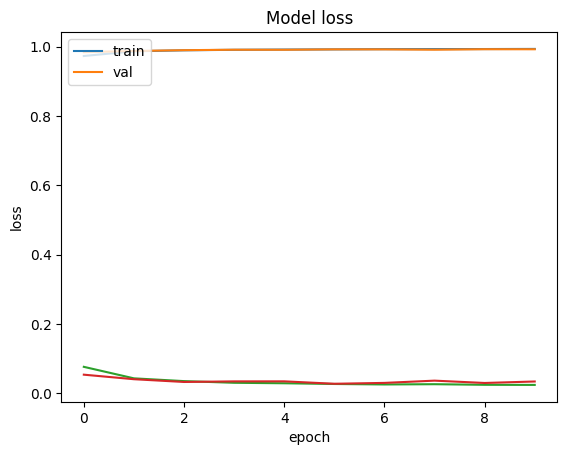

In [20]:
i=1
epochs=settings[i]['epochs']
batch_size=settings[i]['batch_size']
optimizer=settings[i]['optimizer']
optimizer_name=settings[i]['optimizer_name']
model_name=settings[i]['model_name']
model=settings[i]['model'] 
print(settings[i])
history=training(model_name=model_name,model=model,epochs=epochs,optimizer=optimizer,batch_size=batch_size,optimizer_name=optimizer_name)
plot_save_charts(model_setting=settings[i],history=history)
with open(f'models/{model_name}/model_result_{optimizer_name}__{batch_size}.txt','w') as f:
        f.write(f'Results {history.history}')
        f.write(f'Param {history.params}')
keras.backend.clear_session()
model. reset_states()

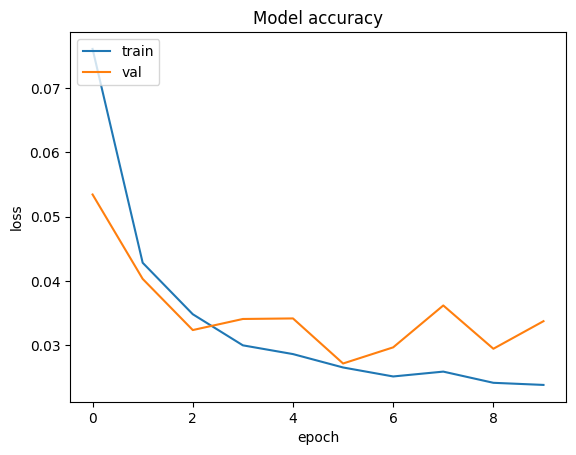

In [23]:
history.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'models/{model_name}/charts/accuracy.png')